In [682]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_validate

from sklearn.base import TransformerMixin
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [683]:
train = pd.read_csv(r"train.csv", index_col=False)
print("DF Size:" ,train.shape)
train.head(5)

DF Size: (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [684]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [685]:
train.describe(include =['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [686]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [687]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [688]:
def fill_nan_with_frequencies(column):
    # Вычисляем частоты для каждого уникального значения в колонке
    frequencies = column.value_counts(normalize=True)
    
    # Создаем список значений для заполнения пропусков на основе частот
    values = frequencies.index
    probabilities = frequencies.values
    
    # Заменяем NaN случайными значениями на основе распределения частот
    nan_indices = column.isna()  # Получаем маску NaN
    
    # Используем np.random.choice для генерации значений по частотам
    fill_values = np.random.choice(values, size=nan_indices.sum(), p=probabilities)
    
    # Возвращаем колонку с заполненными значениями
    column.loc[nan_indices] = fill_values
    return column



PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side 
can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [689]:
def featureEngine(x):
    columns = x.columns
    for i in columns:
        if x[i].isnull().any():
            x[i] = fill_nan_with_frequencies(x[i].copy())

    x[['PassengerNumber', 'PassengerId']] = x['PassengerId'].astype(str).str.split("_", n=1, expand=True)
    x[['deck','numofcabinandside']] = x['Cabin'].astype(str).str.split("/", n=1, expand=True)
    x[['numofcabin','side']] = x['numofcabinandside'].astype(str).str.split("/", n=1, expand=True)

    x['Age'] = x['Age'].astype(int)
    x['RoomService'] = x['RoomService'].astype(int)
    x['FoodCourt'] = x['FoodCourt'].astype(int)
    x['ShoppingMall'] = x['ShoppingMall'].astype(int)
    x['Spa'] = x['Spa'].astype(int)
    x['VRDeck'] = x['VRDeck'].astype(int)
    x['PassengerNumber'] = x['PassengerNumber'].astype(int)
    x['numofcabin'] = x['numofcabin'].astype(int)

    #x.drop(['Cabin'], axis=1, inplace=True)
    x.drop(['numofcabinandside'], axis=1, inplace=True)
    x.drop(['PassengerId'], axis=1, inplace=True)
    x.drop(['Cabin'], axis=1, inplace=True)

    x['VIP'] = x['VIP'].apply(lambda value: True if value == True else False)
    x['CryoSleep'] = x['CryoSleep'].apply(lambda value: True if value == True else False)
    return x

In [690]:
featureEngine(train)
train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerNumber,deck,numofcabin,side
0,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False,1,B,0,P
1,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True,2,F,0,S
2,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False,3,A,0,S
3,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False,3,A,0,S
4,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True,4,F,1,S
5,Earth,False,PSO J318.5-22,44,False,0,483,0,291,0,Sandie Hinetthews,True,5,F,0,P
6,Earth,False,TRAPPIST-1e,26,False,42,1539,3,0,0,Billex Jacostaffey,True,6,F,2,S
7,Earth,True,TRAPPIST-1e,28,False,0,0,0,0,0,Candra Jacostaffey,True,6,G,0,S
8,Earth,False,TRAPPIST-1e,35,False,0,785,17,216,0,Andona Beston,True,7,F,3,S
9,Europa,True,55 Cancri e,14,False,0,0,0,0,0,Erraiam Flatic,True,8,B,1,P


In [691]:
#HomePlanet	CryoSleep
#Destination Age	VIP	RoomService	FoodCourt	ShoppingMall	Spa	VRDeck	Name	
#Transported	PassengerNumber	deck	numofcabian	side
#change the order of col
new_order = ['PassengerNumber',
             'Name',
             'HomePlanet',
             'Destination',
             'deck',
             'numofcabin',
             'side',
             'Age',
             'CryoSleep',
             'VIP',
             'RoomService',
             'FoodCourt',
             'ShoppingMall',
             'Spa',
             'VRDeck',
             'Transported']  
train = train.reindex(columns=new_order)
train.head(5)


,PassengerNumber,Name,HomePlanet,Destination,deck,numofcabin,side,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,Maham Ofracculy,Europa,TRAPPIST-1e,B,0,P,39,False,False,0,0,0,0,0,False
1,2,Juanna Vines,Earth,TRAPPIST-1e,F,0,S,24,False,False,109,9,25,549,44,True
2,3,Altark Susent,Europa,TRAPPIST-1e,A,0,S,58,False,True,43,3576,0,6715,49,False
3,3,Solam Susent,Europa,TRAPPIST-1e,A,0,S,33,False,False,0,1283,371,3329,193,False
4,4,Willy Santantines,Earth,TRAPPIST-1e,F,1,S,16,False,False,303,70,151,565,2,True


In [692]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PassengerNumber  8693 non-null   int64 
 1   Name             8693 non-null   object
 2   HomePlanet       8693 non-null   object
 3   Destination      8693 non-null   object
 4   deck             8693 non-null   object
 5   numofcabin       8693 non-null   int64 
 6   side             8693 non-null   object
 7   Age              8693 non-null   int64 
 8   CryoSleep        8693 non-null   bool  
 9   VIP              8693 non-null   bool  
 10  RoomService      8693 non-null   int64 
 11  FoodCourt        8693 non-null   int64 
 12  ShoppingMall     8693 non-null   int64 
 13  Spa              8693 non-null   int64 
 14  VRDeck           8693 non-null   int64 
 15  Transported      8693 non-null   bool  
dtypes: bool(3), int64(8), object(5)
memory usage: 908.5+ KB


In [693]:
print(train['Destination'].unique())
train.describe(include=['O'])

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']


,Name,HomePlanet,Destination,deck,side
count,8693,8693,8693,8693,8693
unique,8473,3,3,8,2
top,Dia Cartez,Earth,TRAPPIST-1e,F,S
freq,3,4708,6036,2856,4391


In [694]:
#le = LabelEncoder()
#for i in ['deck', 'Name','HomePlanet', 'Destination', 'side']:
#    train[i] = le.fit_transform(train[i])
#
#train.head(5)

# Initialize BinaryEncoder
encoder = BinaryEncoder(cols=['HomePlanet', 'Destination', 'side'])

# Fit and transform the DataFrame
train = encoder.fit_transform(train)
# Initialize the Label Encoder

le = LabelEncoder()
for i in ['deck', 'Name']:
    train[i] = le.fit_transform(train[i])

train.head(5)

,PassengerNumber,Name,HomePlanet_0,HomePlanet_1,Destination_0,Destination_1,deck,numofcabin,side_0,side_1,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,5252,0,1,0,1,1,0,0,1,39,False,False,0,0,0,0,0,False
1,2,4502,1,0,0,1,5,0,1,0,24,False,False,109,9,25,549,44,True
2,3,457,0,1,0,1,0,0,1,0,58,False,True,43,3576,0,6715,49,False
3,3,7149,0,1,0,1,0,0,1,0,33,False,False,0,1283,371,3329,193,False
4,4,8319,1,0,0,1,5,1,1,0,16,False,False,303,70,151,565,2,True


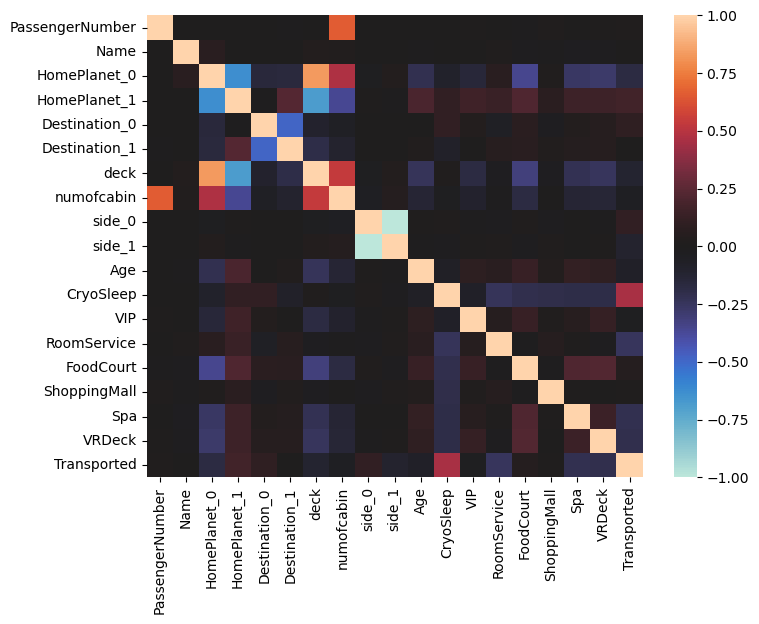

,PassengerNumber,Name,HomePlanet_0,HomePlanet_1,Destination_0,Destination_1,deck,numofcabin,side_0,side_1,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerNumber,1.000000,-0.000349,-0.006197,0.000480,0.007164,-0.013530,-0.002522,0.663346,-0.006379,0.006379,-0.007335,-0.006182,0.015254,-0.001066,-0.008483,0.018263,-0.006184,0.013967,0.021491
Name,-0.000349,1.000000,0.066554,-0.003737,-0.004845,-0.002303,0.034878,0.030918,0.002010,-0.002010,-0.011328,-0.003622,0.002996,0.018323,-0.020434,-0.014943,-0.029155,-0.020618,-0.006966
HomePlanet_0,-0.006197,0.066554,1.000000,-0.628072,-0.152125,-0.160696,0.834154,0.474991,-0.032856,0.032856,-0.213631,-0.091496,-0.144514,0.065660,-0.359168,0.019034,-0.262263,-0.276033,-0.175329
HomePlanet_1,0.000480,-0.003737,-0.628072,1.000000,-0.010528,0.226780,-0.684823,-0.360059,0.011591,-0.011591,0.196846,0.105992,0.158901,0.137983,0.212034,0.071198,0.155587,0.149581,0.167182
Destination_0,0.007164,-0.004845,-0.152125,-0.010528,1.000000,-0.487734,-0.100327,-0.057744,0.006442,-0.006442,0.000566,0.106559,0.037953,-0.058538,0.074497,-0.028867,0.036657,0.047511,0.096325
Destination_1,-0.013530,-0.002303,-0.160696,0.226780,-0.487734,1.000000,-0.190459,-0.101636,0.006455,-0.006455,0.027271,-0.082984,0.003230,0.060304,0.066839,0.029305,0.046067,0.046914,0.000774
deck,-0.002522,0.034878,0.834154,-0.684823,-0.100327,-0.190459,1.000000,0.533079,-0.036973,0.036973,-0.240980,0.018525,-0.176086,-0.028479,-0.317772,-0.031209,-0.221587,-0.248457,-0.115336
numofcabin,0.663346,0.030918,0.474991,-0.360059,-0.057744,-0.101636,0.533079,1.000000,-0.039780,0.039780,-0.128821,-0.034732,-0.095094,-0.012052,-0.178489,0.002435,-0.127909,-0.136868,-0.046576
side_0,-0.006379,0.002010,-0.032856,0.011591,0.006442,0.006455,-0.036973,-0.039780,1.000000,-1.000000,0.009368,0.018005,-0.011486,-0.015766,0.019789,-0.017385,-0.002335,-0.007970,0.101970
side_1,0.006379,-0.002010,0.032856,-0.011591,-0.006442,-0.006455,0.036973,0.039780,-1.000000,1.000000,-0.009368,-0.018005,0.011486,0.015766,-0.019789,0.017385,0.002335,0.007970,-0.101970


In [695]:
corr = train.corr()
plt.figure(1, figsize=(8, 6))  # Increase the height of the heatmap
sns.heatmap(corr,center=0)  # Reduce the font size of annotations
plt.show()
train.corr()

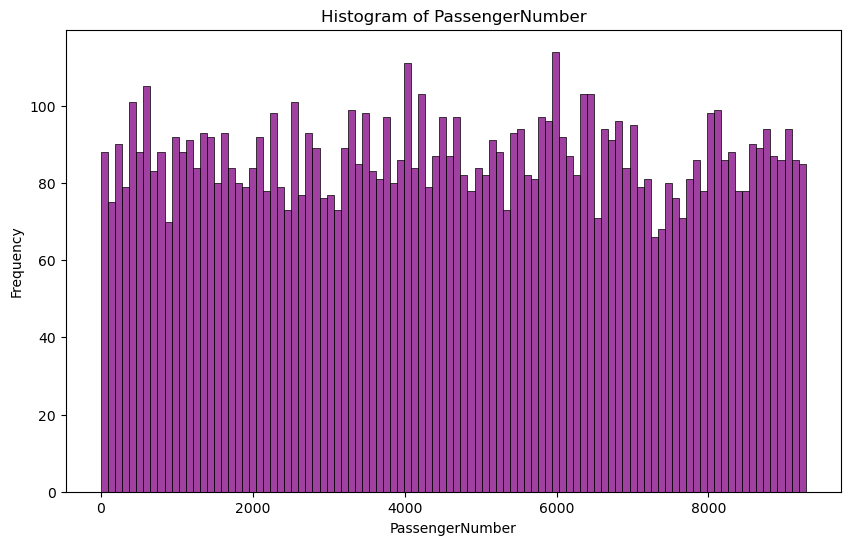

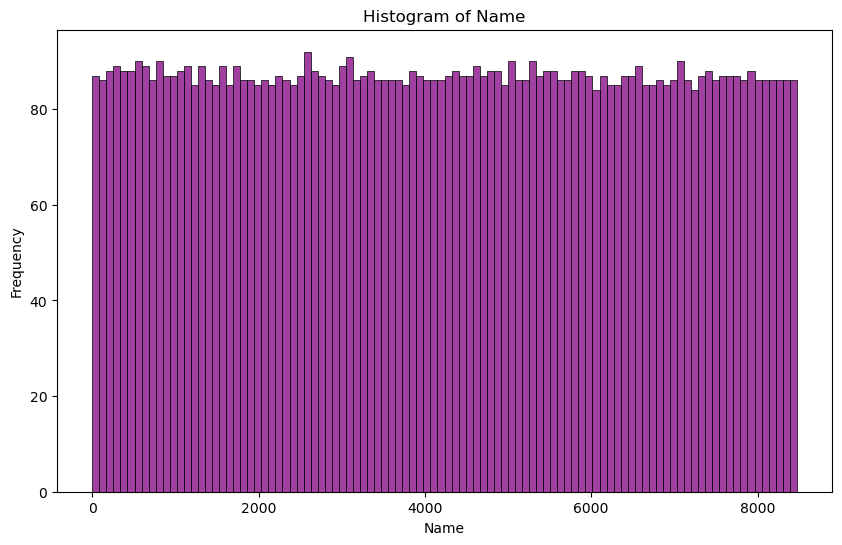

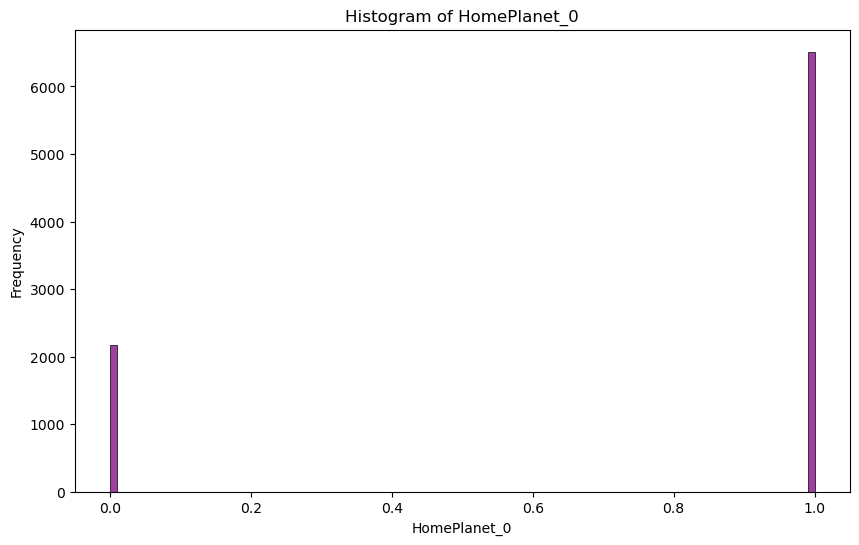

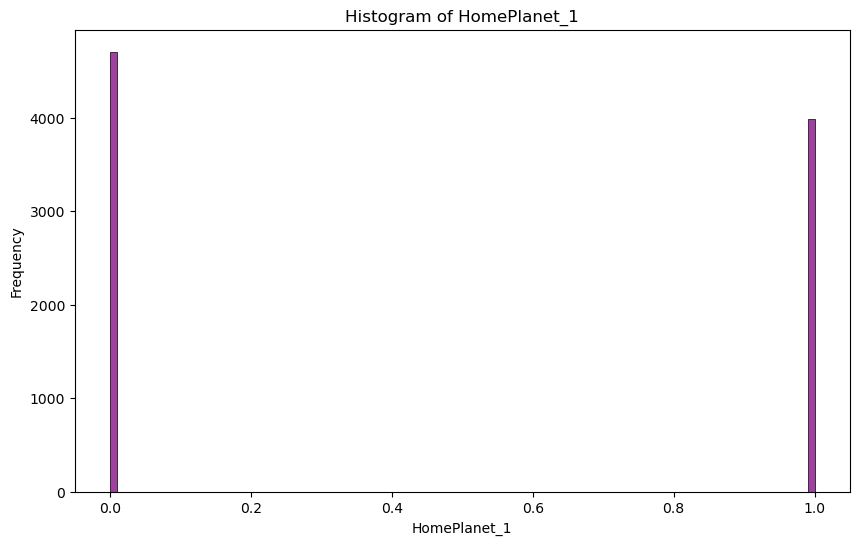

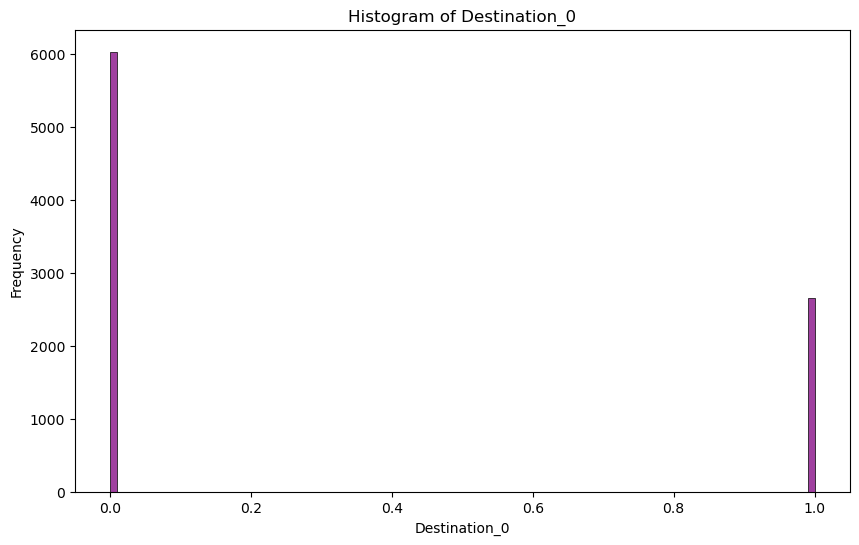

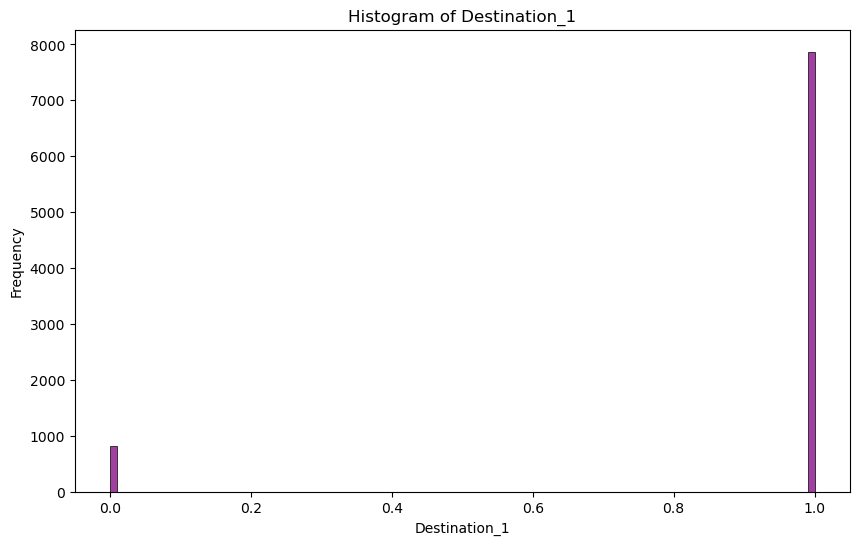

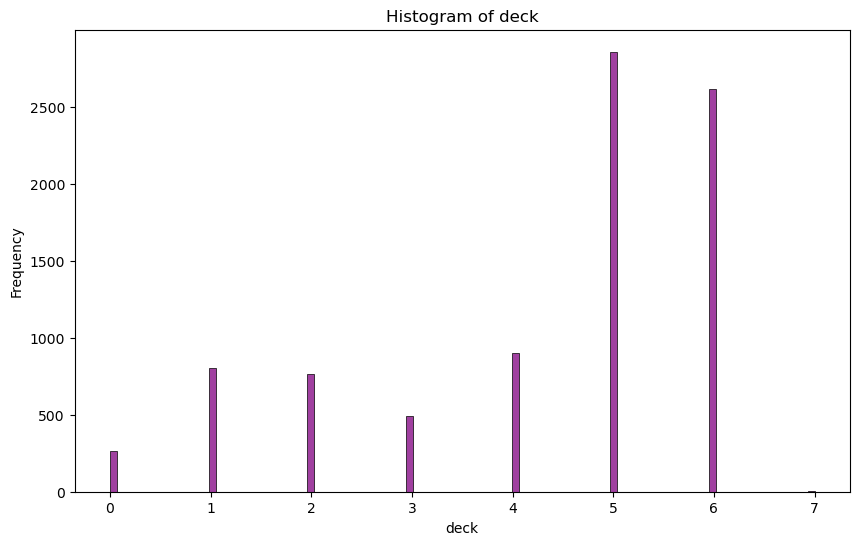

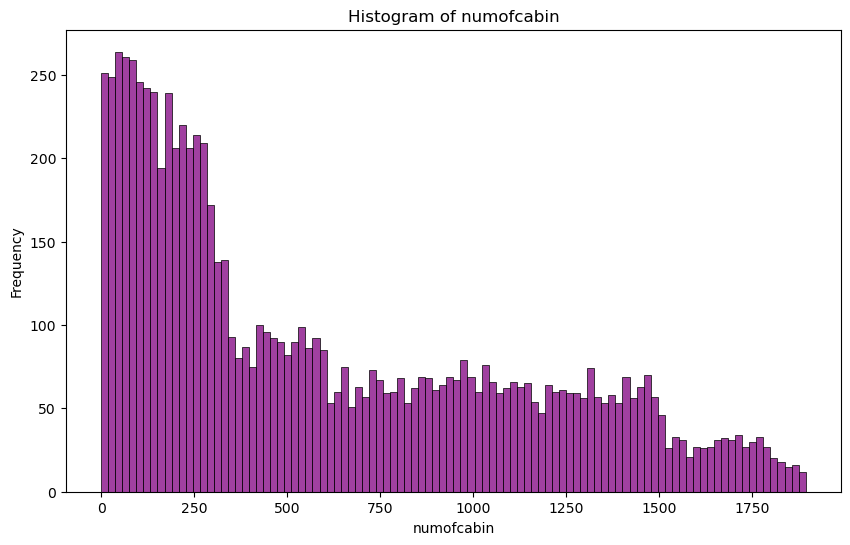

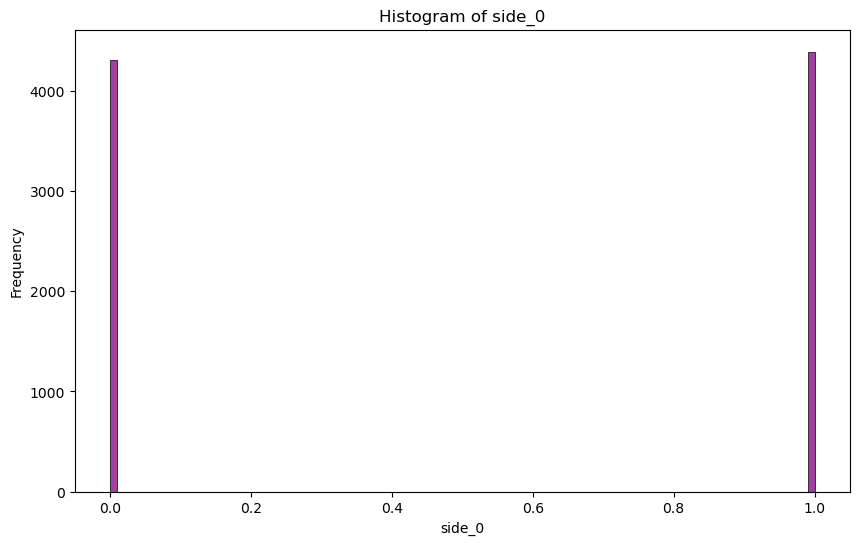

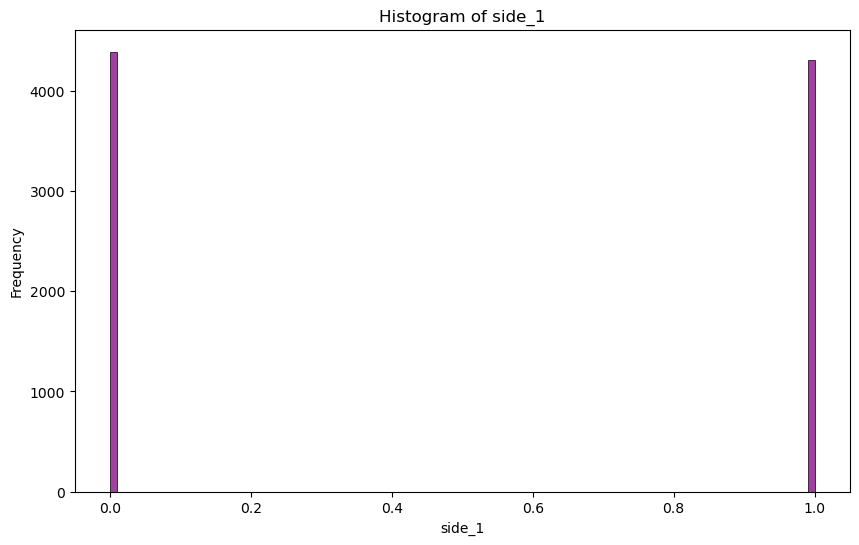

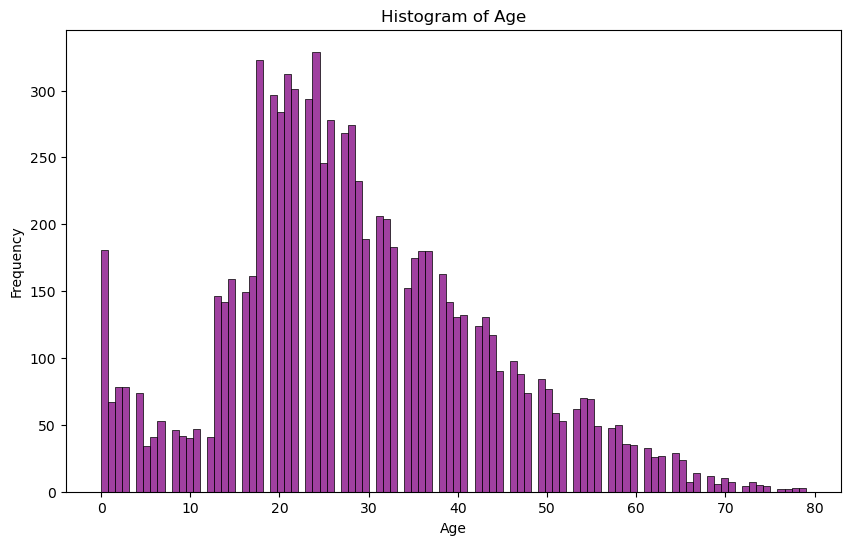

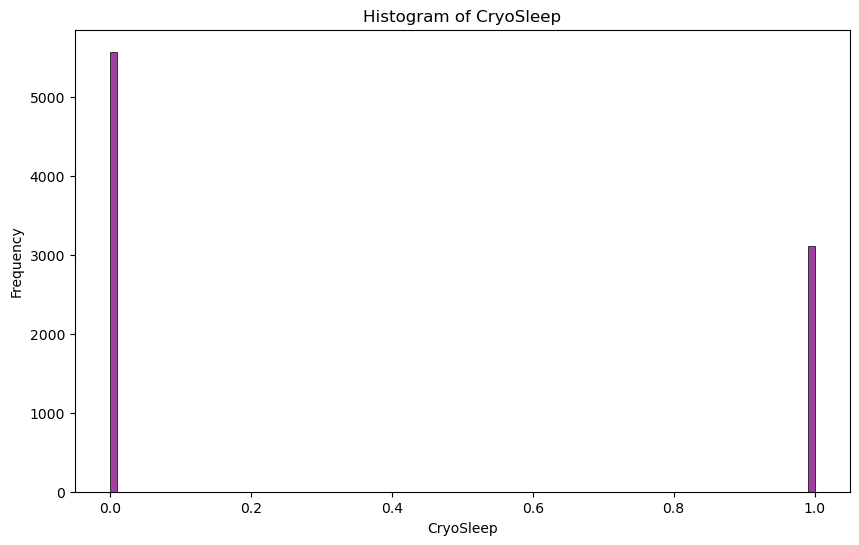

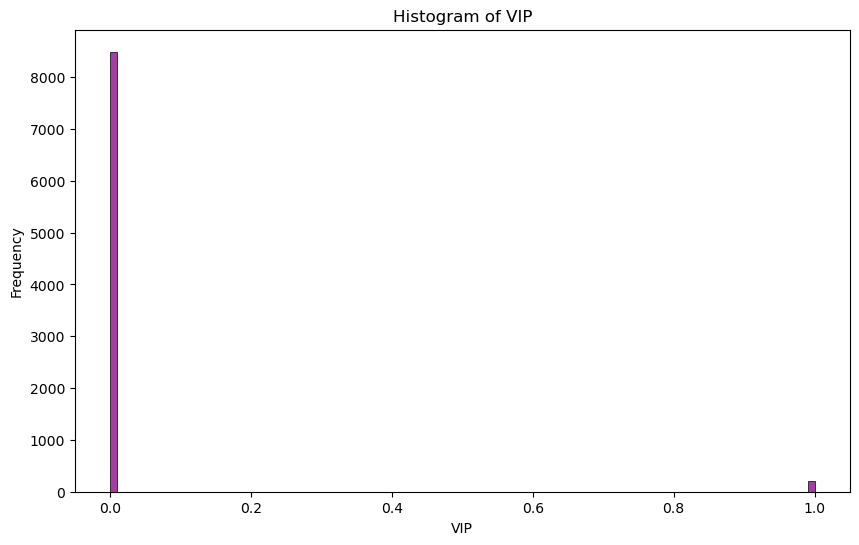

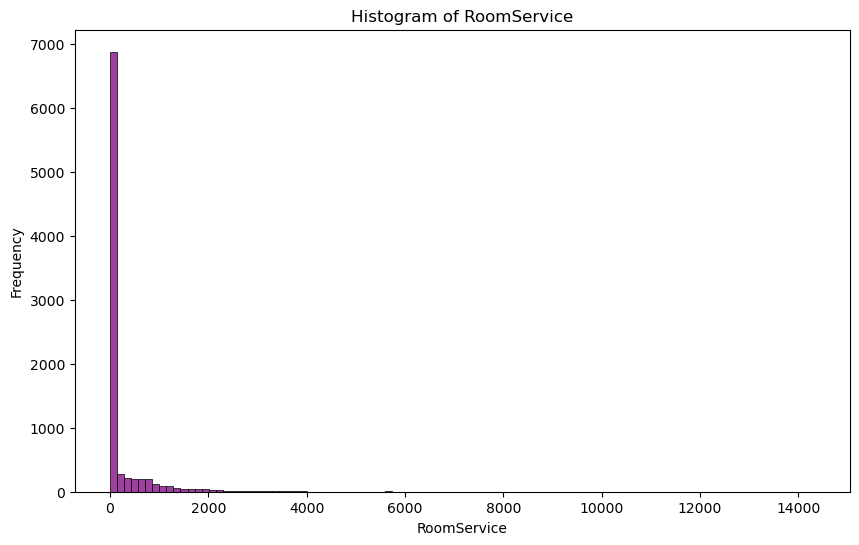

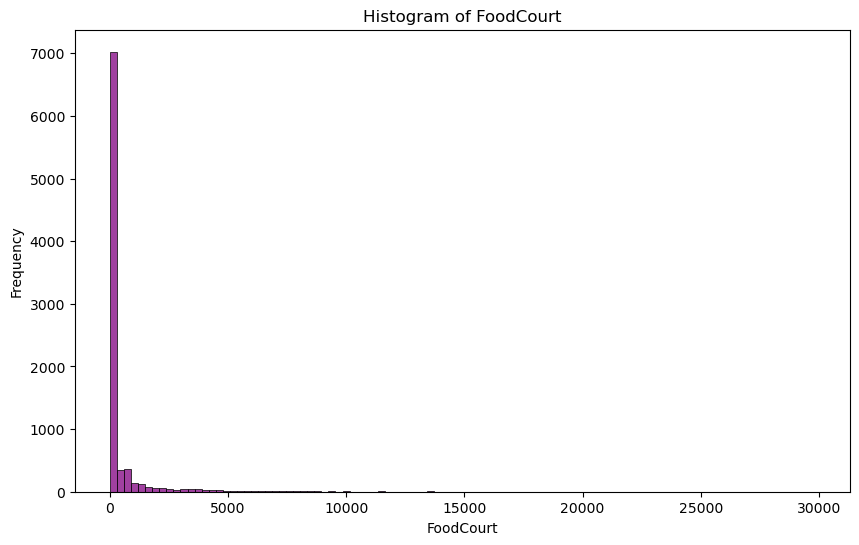

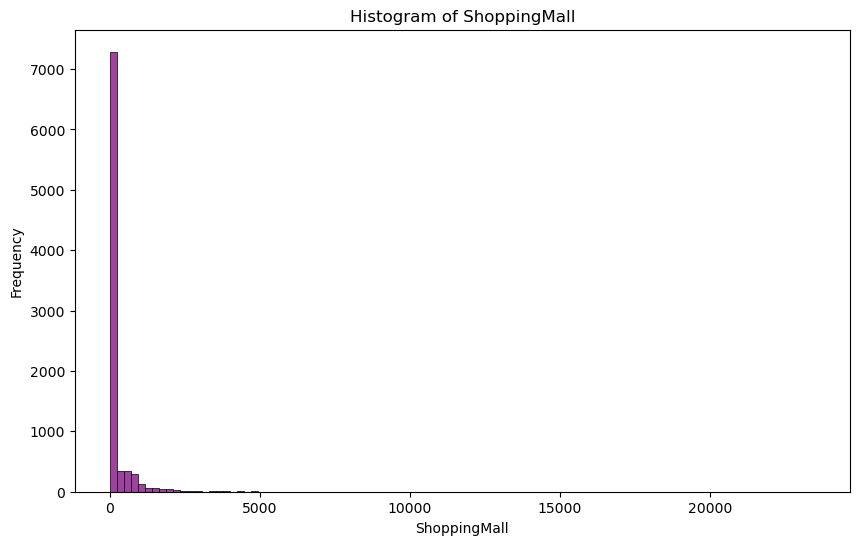

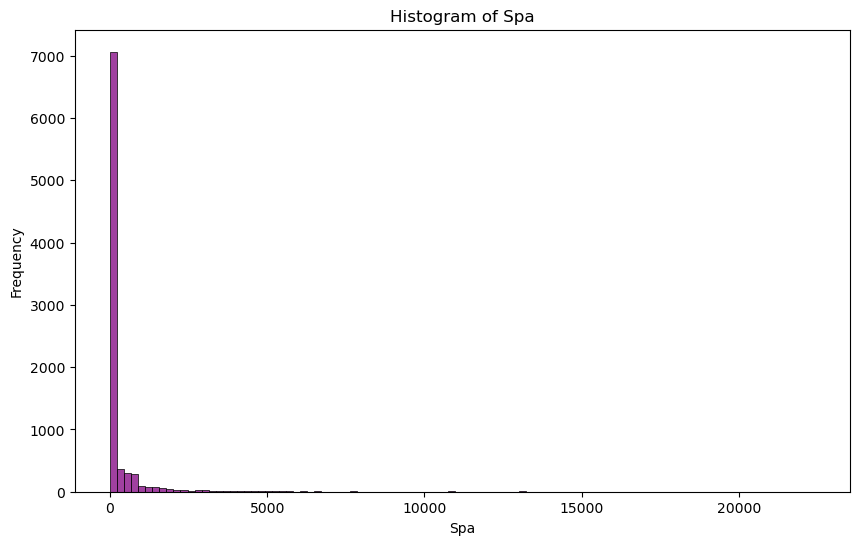

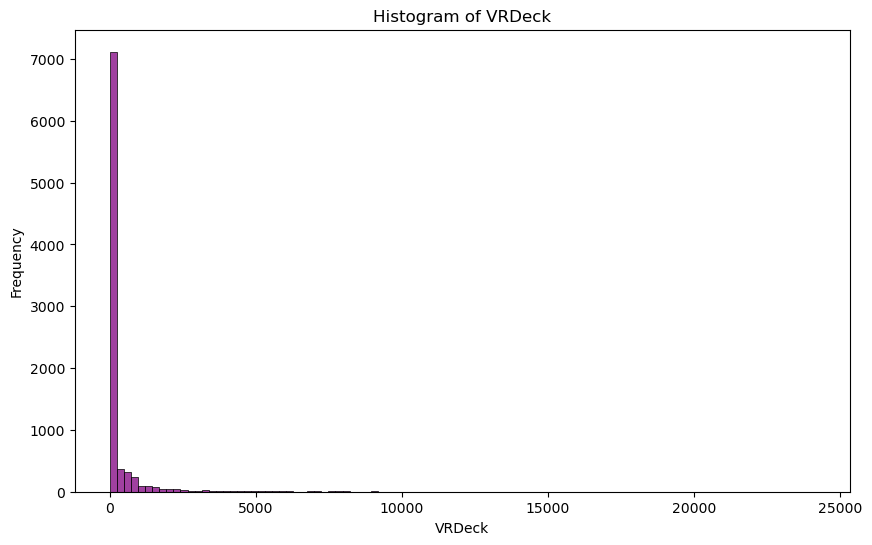

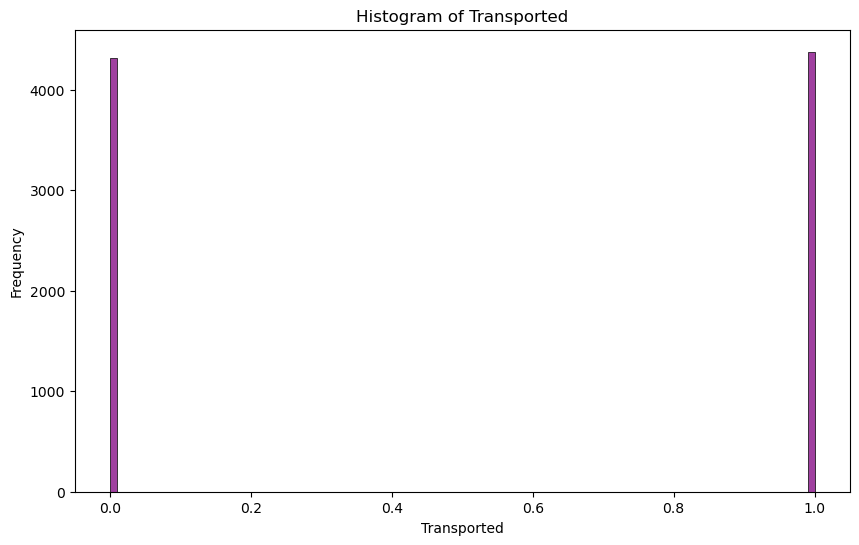

In [696]:
#hisplot for analyze
for i in train.columns:
    plt.figure(figsize=(10, 6))  # Set the figure size for each plot
    sns.histplot(train[i], bins=100, color="purple")
    plt.title(f'Histogram of {i}')  # Title for each histogram
    plt.xlabel(i)  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.show()  # Display the plot

In [697]:
#pick the used models
models = [
    ('lr',LinearRegression()),
    ('Lasso',Lasso()),
    ('Ridge',Ridge()),
    ('ElasticNet', ElasticNet()),
    ('Knn',KNeighborsRegressor()),
    ('DT',DecisionTreeRegressor()),
    ('Bagging',BaggingRegressor()),
    ('RT',RandomForestRegressor()), 
    ('XGB',XGBRegressor()),    
    ('LGBM', LGBMRegressor(verbose=-1)),
    ('CatBoost', CatBoostRegressor(silent=True)),
    ('GBR', GradientBoostingRegressor()),
    ('AdaBoost', AdaBoostRegressor()),
    ('ExtraTrees', ExtraTreesRegressor())
]

In [698]:
#find best models
for model in models:
  print(model[0])
  PL=make_pipeline(transform,
                   StandardScaler(),

                   model[1])

  cv=cross_validate(
    estimator=PL,
    X=x,
    y=y,
    cv=7, #train 6/7 test 1/7
    return_train_score=True,
    scoring=[
             'r2',
             'neg_mean_squared_error',#Negative Mean Squared Error, which is used to measure the average of the squares of the errors. 
             ]
    )
  print(model[0],'train r2 score = ',cv['train_r2'].mean())
  print(model[0],'test r2 score = ',cv['test_r2'].mean())
  print('-'*30)

lr


NameError: name 'transform' is not defined